<a href="https://colab.research.google.com/github/dude123studios/SmarterRing/blob/master/Face_Recognition_Train(Better).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import os
import random
import cv2

In [ ]:
from google.colab import files
files.upload()
#I must manually import my cropped dataset
!mkdir datasets
!unzip bollywood_celeb_faces.zip -d ./datasets

In [3]:
def load_img(image_path):
  with open(image_path, 'rb') as f:
    return np.load(f)

In [4]:
path = './datasets/usr/local/numpy/bollywood_celeb_faces/'
faces = []
for actor in os.listdir(path):
  faces.append([load_img(path+'/'+actor+'/'+actor_img) for actor_img in os.listdir(os.path.join(path,actor))])

In [5]:
pairs1 = []
pairs2 = []
#produces about 500,000 image pairs, so we only take 50,000 for training time
total = 50000
labels = []
#distance between congruent faces is 0
congruent_label = np.asarray([0])
for class_ in faces:
  for i in range(total // len(faces)):
    j = random.randint(0,len(class_)-2)
    k = random.randint(j+1, len(class_)-1)
    pairs1.append(class_[j])
    pairs2.append(class_[k])
    labels.append(congruent_label)
#all non congruent pairs form 40m pairs which is far too much, 
#so we will randomly choose 50,000
#giving us a more reasonable 100,000 total images, since a lot of epochs will be required
#distant pairs will have a sigmoided distance of 1
non_congruent_label = np.asarray([1])
for i in range(total):
  j = random.randint(0,len(faces)-2)
  k = random.randint(j+1,len(faces)-1)
  l = random.randint(0,len(faces[j])-1)
  m = random.randint(0,len(faces[k])-1)
  pairs1.append(faces[j][l])
  pairs2.append(faces[k][m])
  labels.append(non_congruent_label)
del faces

In [6]:
def shuffle_in_unison(a, b, c):
    shuffled_a = np.empty((len(a),64,64,3), dtype=np.float32)
    shuffled_b = np.empty((len(a),64,64,3), dtype=np.float32)
    shuffled_c = np.empty((len(c),1), dtype=np.float32)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
        shuffled_c[new_index] = c[old_index]
    return shuffled_a, shuffled_b, shuffled_c
pairs1, pairs2, labels = shuffle_in_unison(pairs1, pairs2, labels)

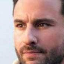

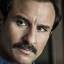

label:  [0.]


In [7]:
from google.colab.patches import cv2_imshow
cv2_imshow((pairs1[600]+1)*127.5)
cv2_imshow((pairs2[600]+1)*127.5)
print('label: ', str(labels[600]))

We have one model which learns about facial features with conv layers and another that learns facial diferentiation  with just a couple of dense layers to a singular nueron which will be 0 for true and 1 for false wether or not two faces are of the same person

In [8]:
class CNN_Block(tf.keras.Model):
  def __init__(self, num_filters, conv_size):
    super(CNN_Block, self).__init__()
    self.conv = Conv2D(num_filters, conv_size, padding='same')
    self.bn = BatchNormalization()
    self.pool = MaxPool2D()

  def call(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = tf.nn.relu(x)
    x = self.pool(x)
    return x

In [9]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    self.block1 = CNN_Block(32, 3)
    self.block2 = CNN_Block(64, 3)
    self.block3 = CNN_Block(128, 3)
    self.block4 = CNN_Block(256, 3)
    self.flatten = Flatten()
    self.dense = Dense(1024, activation='relu')

  def call(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.flatten(x)
    x = self.dense(x)
    return x

In [25]:
class Euclidean_Distance(tf.keras.Model):
  def __init__(self):
    super(Euclidean_Distance, self).__init__()
    self.dense1 = Dense(512, activation='relu')
    self.dense2 = Dense(128, activation='relu')
    self.dense3 = Dense(1, activation='sigmoid')

  def call(self, xA, xB):
    concat = tf.concat((xA,xB),axis=-1)
    x = self.dense1(concat)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

In [26]:
def build_model():
  imgA = Input((64,64,3), dtype=tf.float32, name='inputA')
  imgB = Input((64,64,3), dtype=tf.float32, name='inputB')
  encoder = Encoder()
  featA = encoder(imgA)
  featB = encoder(imgB)
  dist = Euclidean_Distance()
  outputs = dist(featA, featB)
  model = tf.keras.Model(inputs=(imgA, imgB),outputs=outputs)
  
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics='accuracy')
  model.summary()
  return model

In [ ]:
with tf.device('gpu:0'):
  inputs = {'inputA':pairs1, 'inputB':pairs2}
  model = build_model()
  model.fit(inputs, labels, epochs=150, batch_size=64)

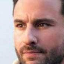

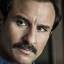

label:  [0.]
Model pred:  [[0.00119848]]


In [33]:
out = model({'inputA':np.expand_dims(pairs1[600],axis=0),'inputB':np.expand_dims(pairs2[600],axis=0)})
from google.colab.patches import cv2_imshow
cv2_imshow((pairs1[600]+1)*127.5)
cv2_imshow((pairs2[600]+1)*127.5)
print('label: ', str(labels[600]))
print('Model pred: ',str(out.numpy()))

In [29]:
model.save_weights('face_recogniton.h5')